In [5]:
import sys, platform, torch
print("Python:", sys.version.split()[0], "| SO:", platform.system(), platform.release())
print("PyTorch:", torch.__version__, "| CUDA disponible:", torch.cuda.is_available())


Python: 3.10.11 | SO: Windows 10
PyTorch: 2.1.0+cu121 | CUDA disponible: True


In [7]:
import os, csv
from pathlib import Path
import pandas as pd

FILENAME_CANDIDATES = [
    "corpus_politico_codificado_utf8.csv",
    "corpus_politico_codificado.csv",
    "dataset.csv",
]

# Buscar archivo en el proyecto
hits = []
for name in FILENAME_CANDIDATES:
    hits = list(Path.cwd().rglob(name))
    if hits:
        break

if not hits:
    raise FileNotFoundError("No encontré el dataset. Coloca el CSV en la carpeta del notebook o ajusta FILENAME_CANDIDATES.")

DATA_PATH = hits[0]
print("✅ Dataset:", DATA_PATH)

# Intento robusto de lectura
df_raw = pd.read_csv(DATA_PATH, encoding="utf-8", engine="python", on_bad_lines="skip")
print("Shape leído:", df_raw.shape)
df_raw.head(3)


✅ Dataset: d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\data\processed\corpus_politico_codificado_utf8.csv
Shape leído: (1000, 1)


,"texto,etiqueta,label"
0,"""Ese candidato solo sabe hablar, pero nunca ha..."
1,"""Quienes nos critican desde Lima no entienden ..."
2,"""Habla de moral, pero no puede explicar de qué..."


In [8]:
import re

def infer_text_and_label_columns(df):
    cols = [c.lower() for c in df.columns]
    # Candidatas de texto
    text_col = None
    for c in ["text", "texto", "sentence", "frase", "utterance"]:
        if c in cols:
            text_col = df.columns[cols.index(c)]
            break
    # Candidatas de etiqueta
    label_col = None
    for c in ["labels","label","etiqueta","target","clase","categoria","y"]:
        if c in cols:
            label_col = df.columns[cols.index(c)]
            break
    return text_col, label_col

text_col, label_col = infer_text_and_label_columns(df_raw)

def parse_misaligned_row(s: str):
    # Ej: '"El cambio ...",retorica_vacia,3'  -> (texto, nombre, id)
    rdr = csv.reader([str(s)], delimiter=",", quotechar='"', skipinitialspace=True)
    parts = next(rdr)
    txt = parts[0].strip().strip('"') if parts else ""
    lname, lid = None, None
    if len(parts) >= 3 and str(parts[-1]).strip().isdigit():
        lid = int(str(parts[-1]).strip())
        lname = str(parts[-2]).strip()
    elif len(parts) >= 2:
        maybe = str(parts[-1]).strip()
        if maybe.isdigit():
            lid = int(maybe)
        else:
            lname = maybe
    return txt, lname, lid

if text_col is None and label_col is None and df_raw.shape[1] == 1:
    # Formato B: todo en una sola columna
    solo = df_raw.columns[0]
    texts, lids, lnames = [], [], []
    for s in df_raw[solo].tolist():
        t, ln, li = parse_misaligned_row(s)
        texts.append(t); lids.append(li); lnames.append(ln)
    df = pd.DataFrame({"text": texts})
    # decidir labels
    if any(li is not None for li in lids):
        df["label_id"] = [int(li) if li is not None else None for li in lids]
    elif any(ln is not None for ln in lnames):
        df["label_name"] = lnames
    else:
        raise ValueError("No se pudieron extraer etiquetas. Revisa el CSV.")
else:
    # Formato A u otros: ya hay columnas
    df = df_raw.copy()
    if text_col is None:
        # intenta deducir: busca la columna más larga como texto
        cand = max(df.columns, key=lambda c: df[c].astype(str).str.len().mean())
        text_col = cand
    df.rename(columns={text_col: "text"}, inplace=True)
    if label_col:
        if label_col != "label":
            df.rename(columns={label_col: "label"}, inplace=True)

print(df.head(3))
print("Columnas:", list(df.columns))


                                                text  label_id
0  Ese candidato solo sabe hablar, pero nunca ha ...         0
1  Quienes nos critican desde Lima no entienden l...         0
2  Habla de moral, pero no puede explicar de qué ...         0
Columnas: ['text', 'label_id']


In [9]:
import numpy as np

if "label_id" in df.columns:
    if df["label_id"].isna().any():
        raise ValueError("Hay filas sin label_id. Limpia el CSV o completa los ids.")
    labels = df["label_id"].astype(int).tolist()
    classes = sorted(set(labels))
    # Re-map a 0..K-1 si no está denso
    remap = {old:i for i, old in enumerate(sorted(classes))}
    df["labels"] = [remap[x] for x in labels]
    id2label = {i: f"CLASS_{i}" for i in range(len(remap))}
    label2id = {v:k for k,v in id2label.items()}
elif "label" in df.columns:
    # Puede ser string o int
    if np.issubdtype(df["label"].dtype, np.number):
        labels = df["label"].astype(int).tolist()
        classes = sorted(set(labels))
        remap = {old:i for i, old in enumerate(sorted(classes))}
        df["labels"] = [remap[x] for x in labels]
        id2label = {i: f"CLASS_{i}" for i in range(len(remap))}
        label2id = {v:k for k,v in id2label.items()}
    else:
        names = sorted(df["label"].astype(str).unique().tolist())
        name2id = {n:i for i,n in enumerate(names)}
        df["labels"] = df["label"].astype(str).map(name2id).astype(int)
        id2label = {i:n for n,i in name2id.items()}
        label2id = name2id
elif "label_name" in df.columns:
    names = sorted(df["label_name"].astype(str).unique().tolist())
    name2id = {n:i for i,n in enumerate(names)}
    df["labels"] = df["label_name"].astype(str).map(name2id).astype(int)
    id2label = {i:n for n,i in name2id.items()}
    label2id = name2id
else:
    raise ValueError("No encuentro columna de etiqueta. Debe existir 'label_id', 'label' o 'label_name'.")

num_labels = int(df["labels"].max()) + 1
print("✅ num_labels:", num_labels)
print("Muestra:", df[["text","labels"]].head(3))


✅ num_labels: 4
Muestra:                                                 text  labels
0  Ese candidato solo sabe hablar, pero nunca ha ...       0
1  Quienes nos critican desde Lima no entienden l...       0
2  Habla de moral, pero no puede explicar de qué ...       0


In [12]:
for c in sorted(df["labels"].unique()):
    m = df[df["labels"]==c].sample(min(2, (df["labels"]==c).sum()), random_state=42)
    print(f"\n== Clase {c} ==")
    for t in m["text"].tolist():
        print("-", t[:140])




== Clase 0 ==
- Promete renovación y revive viejos vicios
- El que se cree estadista no puede ni manejar su propia familia política

== Clase 1 ==
- Ellos llaman rebeldía a pedir justicia
- Nosotros votamos con esperanza, ellos gobiernan con indiferencia

== Clase 2 ==
- El 70 % de los estudiantes de secundaria no entiende textos financieros
- El sector minero representa cerca del 10 % del PBI nacional

== Clase 3 ==
- El amor por la patria vencerá cualquier obstáculo
- Nuestro destino está en nuestras manos y en nuestra fe


Conteo global: {0: 250, 3: 250, 2: 250, 1: 250}


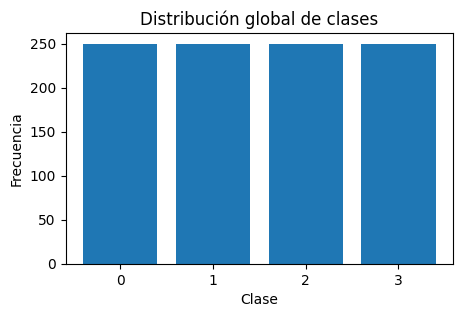

Pesos preliminares (preview, global): {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [13]:
# === Balance global de clases (visual) ===
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

conteo = Counter(df["labels"])
num_labels = int(df["labels"].max()) + 1
print("Conteo global:", dict(conteo))

# Gráfico simple de barras
xs = list(range(num_labels))
ys = [conteo.get(i, 0) for i in xs]
plt.figure(figsize=(5,3))
plt.bar(xs, ys)
plt.xticks(xs)
plt.title("Distribución global de clases")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

# Pesos preliminares estilo 'balanced' (para referencia)
N = len(df)
K = num_labels
class_weights_preview = {i: (N / (K * (conteo.get(i, 1)))) for i in xs}
print("Pesos preliminares (preview, global):", class_weights_preview)


In [14]:
# Paso 5 — Split 80/20 estratificado
from sklearn.model_selection import train_test_split
from collections import Counter

train_df, test_df = train_test_split(
    df[["text","labels"]],
    test_size=0.20,
    random_state=42,
    stratify=df["labels"]
)

print("Tamaño train/test:", len(train_df), len(test_df))
print("Distribución train:", Counter(train_df["labels"]))
print("Distribución test :", Counter(test_df["labels"]))


Tamaño train/test: 800 200
Distribución train: Counter({2: 200, 1: 200, 0: 200, 3: 200})
Distribución test : Counter({2: 50, 1: 50, 3: 50, 0: 50})


In [15]:
# Paso 6 — Tokenización con BETO
from datasets import Dataset
from transformers import AutoTokenizer

MODEL_NAME_OR_PATH = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_OR_PATH, use_fast=True)

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

def tok_fn(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_train = train_ds.map(
    tok_fn, batched=True,
    remove_columns=[c for c in train_ds.column_names if c not in ["text","labels"]]
)
tokenized_test = test_ds.map(
    tok_fn, batched=True,
    remove_columns=[c for c in test_ds.column_names if c not in ["text","labels"]]
)

tokenized_train = tokenized_train.with_format("torch")
tokenized_test  = tokenized_test.with_format("torch")

print("Keys ejemplo:", tokenized_train[0].keys())  # debe incluir: input_ids, token_type_ids, attention_mask, labels


d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Keys ejemplo: dict_keys(['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'])


In [17]:
# === Modelo + args + pérdida ponderada (todo en uno) ===
import torch
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

# 1) Modelo BETO (num_labels desde el df original)
num_labels = int(df["labels"].max()) + 1
id2label = {i: f"CLASS_{i}" for i in range(num_labels)}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_OR_PATH,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# 2) Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 3) Métricas
def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    y_pred = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
    }

# 4) Training args (ajusta batch/epochs según tu GPU)
training_args = TrainingArguments(
    output_dir="./beto_cls_runs",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
)

# 5) Pesos de clase según el split de TRAIN (importante: usar train_df)
train_counts = Counter(train_df["labels"])
K = num_labels
N_train = len(train_df)
class_weights = torch.tensor([N_train / (K * train_counts.get(i, 1)) for i in range(K)], dtype=torch.float)
print("Pesos de clase (train):", {i: float(class_weights[i]) for i in range(K)})

# 6) Trainer con CrossEntropy ponderada
from torch.nn import CrossEntropyLoss

class WeightedCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        w = class_weights.to(logits.device)
        loss_fct = CrossEntropyLoss(weight=w)
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

weighted_trainer = WeightedCELossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 7) Entrenar
weighted_trainer.train()

# 8) Evaluar y guardar
metrics = weighted_trainer.evaluate()
print(metrics)
weighted_trainer.save_model("./beto_cls_best")
tokenizer.save_pretrained("./beto_cls_best")


d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pesos de clase (train): {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


  0%|          | 0/150 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.4241, 'learning_rate': 1.3466666666666668e-05, 'epoch': 1.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.02038070745766163, 'eval_accuracy': 1.0, 'eval_f1_macro': 1.0, 'eval_runtime': 0.3844, 'eval_samples_per_second': 520.33, 'eval_steps_per_second': 18.212, 'epoch': 1.0}
{'loss': 0.0142, 'learning_rate': 6.800000000000001e-06, 'epoch': 2.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.004576809238642454, 'eval_accuracy': 1.0, 'eval_f1_macro': 1.0, 'eval_runtime': 0.1501, 'eval_samples_per_second': 1332.521, 'eval_steps_per_second': 46.638, 'epoch': 2.0}
{'loss': 0.0055, 'learning_rate': 1.3333333333333336e-07, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.0036762880627065897, 'eval_accuracy': 1.0, 'eval_f1_macro': 1.0, 'eval_runtime': 0.1549, 'eval_samples_per_second': 1290.803, 'eval_steps_per_second': 45.178, 'epoch': 3.0}
{'train_runtime': 77.8903, 'train_samples_per_second': 30.813, 'train_steps_per_second': 1.926, 'train_loss': 0.14795557896296183, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.02038070745766163, 'eval_accuracy': 1.0, 'eval_f1_macro': 1.0, 'eval_runtime': 0.4714, 'eval_samples_per_second': 424.282, 'eval_steps_per_second': 14.85, 'epoch': 3.0}


('./beto_cls_best\\tokenizer_config.json',
 './beto_cls_best\\special_tokens_map.json',
 './beto_cls_best\\vocab.txt',
 './beto_cls_best\\added_tokens.json',
 './beto_cls_best\\tokenizer.json')

In [18]:
# === Pesos con el split de TRAIN + Trainer con CrossEntropy ponderada ===
import torch
import numpy as np
from collections import Counter
from transformers import Trainer
from torch.nn import CrossEntropyLoss

# 1) Recalcular pesos SOLO en train (importante)
train_counts = Counter(train_df["labels"])  # usa el split original (no el Dataset HF)
K = int(max(train_counts.keys())) + 1
N_train = len(train_df)
class_weights = torch.tensor([N_train / (K * train_counts.get(i, 1)) for i in range(K)], dtype=torch.float)
print("Pesos de clase (train):", {i: float(class_weights[i]) for i in range(K)})

# 2) Definir un Trainer que use loss ponderada
class WeightedCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # mover pesos al device del modelo
        w = class_weights.to(logits.device)
        loss_fct = CrossEntropyLoss(weight=w)
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# 3) Construir el Trainer (reutiliza tokenizer, data_collator, training_args, compute_metrics y model ya definidos)
weighted_trainer = WeightedCELossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 4) Entrenar con pesos
weighted_trainer.train()


Pesos de clase (train): {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


  0%|          | 0/150 [00:00<?, ?it/s]

{'loss': 0.0107, 'learning_rate': 1.3466666666666668e-05, 'epoch': 1.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.0013520197244361043, 'eval_accuracy': 1.0, 'eval_f1_macro': 1.0, 'eval_runtime': 0.1413, 'eval_samples_per_second': 1415.801, 'eval_steps_per_second': 49.553, 'epoch': 1.0}
{'loss': 0.0012, 'learning_rate': 6.800000000000001e-06, 'epoch': 2.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.000732801912818104, 'eval_accuracy': 1.0, 'eval_f1_macro': 1.0, 'eval_runtime': 0.1569, 'eval_samples_per_second': 1274.661, 'eval_steps_per_second': 44.613, 'epoch': 2.0}
{'loss': 0.0009, 'learning_rate': 1.3333333333333336e-07, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.0006390346679836512, 'eval_accuracy': 1.0, 'eval_f1_macro': 1.0, 'eval_runtime': 0.1702, 'eval_samples_per_second': 1174.921, 'eval_steps_per_second': 41.122, 'epoch': 3.0}
{'train_runtime': 66.0378, 'train_samples_per_second': 36.343, 'train_steps_per_second': 2.271, 'train_loss': 0.004258481959501902, 'epoch': 3.0}


TrainOutput(global_step=150, training_loss=0.004258481959501902, metrics={'train_runtime': 66.0378, 'train_samples_per_second': 36.343, 'train_steps_per_second': 2.271, 'train_loss': 0.004258481959501902, 'epoch': 3.0})

## ANALISIS Y EVALUDACION DEL MODELO

  0%|          | 0/7 [00:00<?, ?it/s]

Matriz de confusión:
 [[50  0  0  0]
 [ 0 50  0  0]
 [ 0  0 50  0]
 [ 0  0  0 50]]


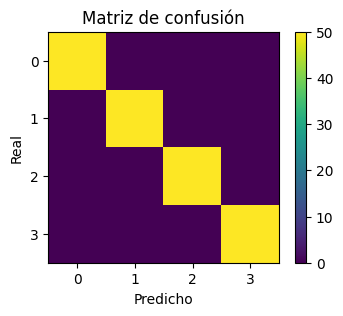


Reporte por clase:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        50
           1     1.0000    1.0000    1.0000        50
           2     1.0000    1.0000    1.0000        50
           3     1.0000    1.0000    1.0000        50

    accuracy                         1.0000       200
   macro avg     1.0000    1.0000    1.0000       200
weighted avg     1.0000    1.0000    1.0000       200



In [19]:
# === Matriz de confusión y reporte por clase ===
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Predicciones en test
pred = weighted_trainer.predict(tokenized_test)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=-1)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print("Matriz de confusión:\n", cm)

# Plot simple
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión")
plt.colorbar()
plt.xticks(range(cm.shape[0]))
plt.yticks(range(cm.shape[0]))
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Reporte por clase
print("\nReporte por clase:")
print(classification_report(y_true, y_pred, digits=4))


In [23]:
import hashlib
train_hash = set(train_df["text"].apply(lambda x: hashlib.md5(x.encode()).hexdigest()))
test_hash  = set(test_df["text"].apply(lambda x: hashlib.md5(x.encode()).hexdigest()))
print("Coincidencias train/test:", len(train_hash & test_hash))


Coincidencias train/test: 1


In [20]:
# === Top errores: ejemplos mal clasificados ===
import pandas as pd

# Recuperar textos de test en el mismo orden del Dataset HF
test_texts = test_df.reset_index(drop=True)["text"].tolist()

err_idx = np.where(y_true != y_pred)[0]
rows = []
for i in err_idx[:30]:  # muestra hasta 30; ajusta a gusto
    rows.append({
        "idx": int(i),
        "gold": int(y_true[i]),
        "pred": int(y_pred[i]),
        "text": test_texts[i][:400]  # recorta por seguridad visual
    })
err_df = pd.DataFrame(rows)
err_df.head(10)


""


,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1_macro,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
2,0.0012,6.800000e-06,2.0,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.0,100,0.000733,1.0,1.0,0.1569,1274.661,44.613,NaN,NaN,NaN,NaN,NaN
4,0.0009,1.333333e-07,3.0,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,3.0,150,0.000639,1.0,1.0,0.1702,1174.921,41.122,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,3.0,150,NaN,NaN,NaN,NaN,NaN,NaN,66.0378,36.343,2.271,2.104104e+13,0.004258


<Figure size 500x300 with 0 Axes>

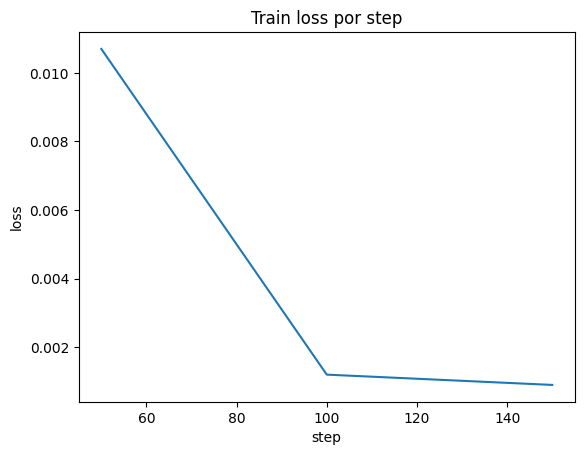

<Figure size 500x300 with 0 Axes>

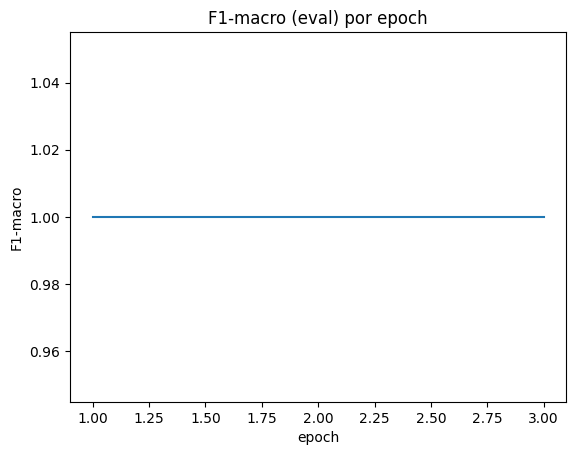

In [21]:
# === Curvas de entrenamiento a partir del log del Trainer ===
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(weighted_trainer.state.log_history)
display(hist.tail())

# Loss de entrenamiento (si está logueado por steps)
if "loss" in hist.columns:
    plt.figure(figsize=(5,3))
    hist.dropna(subset=["loss"]).plot(x="step", y="loss", legend=False)
    plt.title("Train loss por step")
    plt.xlabel("step"); plt.ylabel("loss")
    plt.show()

# Métricas por epoch (eval)
if "eval_f1_macro" in hist.columns:
    plt.figure(figsize=(5,3))
    hist.dropna(subset=["eval_f1_macro"]).plot(x="epoch", y="eval_f1_macro", legend=False)
    plt.title("F1-macro (eval) por epoch")
    plt.xlabel("epoch"); plt.ylabel("F1-macro")
    plt.show()


In [22]:
# === Función de inferencia rápida ===
import torch

def predict_texts(texts, topk=1):
    enc = tokenizer(texts, truncation=True, return_tensors="pt", padding=True)
    enc = {k: v.to(model.device) for k, v in enc.items()}
    model.eval()
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
    preds = probs.argsort(axis=-1)[:, ::-1][:, :topk]
    return preds, probs

ejemplos = [
    "Prometen cambio pero repiten las mismas prácticas de siempre.",
    "Las cifras del INEI muestran un aumento del empleo formal.",
]
preds, probs = predict_texts(ejemplos, topk=2)
for t, pids, pr in zip(ejemplos, preds, probs):
    print("\n", t)
    for rank, pid in enumerate(pids):
        print(f"  top{rank+1}: clase {pid} (p={pr[pid]:.3f})")



 Prometen cambio pero repiten las mismas prácticas de siempre.
  top1: clase 0 (p=0.997)
  top2: clase 1 (p=0.001)

 Las cifras del INEI muestran un aumento del empleo formal.
  top1: clase 2 (p=0.999)
  top2: clase 0 (p=0.001)
